In [2]:
#Carregar as bibliotecas
import tensorflow.keras as keras
import numpy as np
import numpy.random as rd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import  train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
import  sklearn.metrics as skm

## Import Data

In [3]:
#Carregar o dataset
cifar10=keras.datasets.cifar10
(X1,y1),(X2,y2)=cifar10.load_data()
y1=y1.ravel()
y2=y2.ravel()
print('Training set:',X1.shape,X1.dtype)
print('Test set:    ',X2.shape,X2.dtype)
print('Training labels:',y1.shape,y1.dtype)
print('Test labels:    ',y2.shape,y2.dtype)

Training set: (50000, 32, 32, 3) uint8
Test set:     (10000, 32, 32, 3) uint8
Training labels: (50000,) uint8
Test labels:     (10000,) uint8


## Shuffle training set

In [4]:
idx=rd.permutation(X1.shape[0])
X1=X1[idx]
y1=y1[idx]

## Images must be in vector format

In [5]:
X1=X1.reshape((X1.shape[0],32*32*3))*1.
X2=X2.reshape((X2.shape[0],32*32*3))*1.
print('Training set:',X1.shape,X1.dtype)
print('Test set:    ',X2.shape,X2.dtype)

Training set: (50000, 3072) float64
Test set:     (10000, 3072) float64


## Preparation Binary Classification 

Nesta primeira parte do trabalho é realizada a classificação de imagens considerando que existe apenas uma classe positiva, sendo esta "Ship". De acordo com a documentação presente no site é possivel deduzir que a classe "Ship" é representada com o valor y == 8.

In [6]:
y1b=(y1==8)*1
y2b=(y2==8)*1
max_iter=200

## Classifiers - Binary Classification

### Logistic Regression


Para que serve a regressão logística?

A regressão logística é uma técnica estatística supervisionada que tem como objetivo produzir, a partir de um conjunto de observações, um modelo que permita a classificaçar valores tomados por uma variável categórica, frequentemente binária, a partir de uma série de variáveis explicativas contínuas e/ou binárias.

A regressão logística terá um funcionamento similar a regressão linear porém limitado a uma janela de 0 a 1, tornando por isso num problema de classificação binária. Este modelo irá tentar encontrar uma função sigmoid que melhor separe as classes pretendidas.


A regressão logística é utilizada em áreas como as seguintes:

- Em medicina, permite por exemplo determinar os factores que caracterizam um grupo de indivíduos doentes em relação a indivíduos sãos;
- No domínio dos seguros, permite encontrar fracções da clientela que sejam sensíveis a determinada política securitária em relação a um dado risco particular;
- Em instituições financeiras, pode detectar os grupos de risco para a subscrição de um crédito;
- Em econometria, permite explicar uma variável discreta, como por exemplo as intenções de voto em actos eleitorais.

### LinearSVC

Para que serve o LinearSVC?

O LinearSVC é uma técnica de aprendizagem supervisionada baseada em support vector machines. Esta técnica tem como objetivo encontrar hyper-planos que separem ao máximo a data de modo a classifica-la o mais corretamente. 
Para o caso de classificação binária o LinearSVC toma como entrada um conjunto de dados e através da identificação do hyperplano prediz, para cada entrada dada, qual de duas possíveis classes a entrada faz parte.

Estas técnicas são úteis para casos como:

- Categorizar textos e hypertextos;
- Classificar imagens;
- Classificar data de satélites como data de SAR; 
- Reconhecer caracters escritos manualmente;


De modo a encontrar os melhores hyper-parameters pode-se executar um grid search que irá testar as combinações dos parametros com o objetivo de encontrar o mais indicado para o problema em questão. Isto é uma operação que dependendo do numero de parametros e inputs poderá demorar muito tempo. Para diminuir o tempo de execução pode-se diminuir o numero de inputs ou o numero de iterações.

In [ ]:
lr=LogisticRegression(random_state=42, max_iter=max_iter)

params = {
    "C" : [2, 1, .1],
    "solver" : ["lbfgs", "sag", "saga"],
    "penalty" : ["l1", "l2", "elasticnet"],
}
 
gs_lr = GridSearchCV(lr, param_grid=params).fit(X1, y1b)

In [7]:
print(gs_lr.best_params_)

{'C': 1, 'penalty': 'l1', 'solver': 'saga'}


In [ ]:
lsvc=LinearSVC(random_state=42, max_iter=max_iter)

params = {
    "C" : [2, 1, .1],
    "loss" : ["hinge", "squared_hinge"],
    "penalty" : ["l1", "l2", "elasticnet"],
}

gs_lsvc = GridSearchCV(lsvc, param_grid=params).fit(X1, y1b)

In [8]:
print(gs_lsvc.best_params_)

{'C': 2, 'loss': 'hinge', 'penalty': 'l2'}


Devido aos recursos disponibilizados para a realização deste trabalho serem reduzidos e ao tempo de processamento para encontrar os melhores parametros ser extenso utilizou-se um max_iter=100, por forma a reduzir o tempo de espera.

Testou-se com varios valores de max_iter, pelo que se observou que para valores de 100 e 1000, por exemplo, as matrizes de confuzão obtidos com os  classificadores resultantes do treino, apresentam resultados aproximadamente identicos. É tambem importante referir que em nenhuma das situações ocorre convergencia dos classificaodres.

## Binary Classification

### GridSearch

In [ ]:
#1º Classificador Logistic Regression com os melhores hyper-parametros 
lr=LogisticRegression(
    C = gs_lr.best_params_.get("C"),
    solver = gs_lr.best_params_.get("solver"),
    penalty = gs_lr.best_params_.get("penalty"),
    random_state=42, 
    #max_iter=max_iter,
    ).fit(X1,y1b)

In [19]:
#2º Classificador LinearSVC com os melhores hyper-parametros 
lsvc=LinearSVC(
    C = gs_lsvc.best_params_.get("C"),
    loss = gs_lsvc.best_params_.get("loss"),
    penalty = gs_lsvc.best_params_.get("penalty"),
    random_state=42, 
    #max_iter=max_iter,
    ).fit(X1,y1b)

c:\Users\Mihail Ababii\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### Classification

In [12]:
#Predição para o conjutno de teste e criação da matriz de confusão
y2e_lr=lr.predict(X2)
print(confusion_matrix(y2b,y2e_lr))
print('Total number of erros %d (in %d)'%(np.sum(y2b!=y2e_lr),y2b.shape[0]))


[[8728  272]
 [ 760  240]]
Total number of erros 1032 (in 10000)


In [20]:
#Predição para o conjutno de teste e criação da matriz de confusão
y2e_lsvc=lsvc.predict(X2)

print(confusion_matrix(y2b,y2e_lsvc))
print('Total number of erros %d (in %d)'%(np.sum(y2b!=y2e_lsvc),y2b.shape[0]))

[[8563  437]
 [ 750  250]]
Total number of erros 1187 (in 10000)


Atravez da observação das matrizes de confuzão acima, podemos visializar que o LogisticRegression (lr) apresenta um numero total de erros inferior ao LinearSVC (lsvc). No entanto, é importande identificar que ainda que o número total de erros seja superior, é possivel constatar que para o caso do LinearSVC apresenta maior numero de True Positives à custa dum maior número de False Positives.   

In [14]:
# decision_function permite obter a pontuação de confiança que para o Logistic regression será a distancia da amostra para o hyperplano. 
#Através desta função será possivel controlar o thershold para o qual uma amostra será considerada como positiva ou negativa, tornando o modelo mais conservativo ou liberal.
#Dependendo do objetivo de classificação podemos aumentar o thershold tornando-o mais conservativo, de modo a só considerar uma classe positiva quando o modelo tem grandes certezas que a amostra pertence à classe 
#ou mais liberal ao se diminuir o thershold, de modo a que mais amostras sejam consideradas positivas quando existe mais incerteza

r2e_lr = lr.decision_function(X2)
fp_lr, tp_lr, t_lr=skm.roc_curve(y2b,r2e_lr)

r1_lr=np.sum(y2e_lr[y2b==1]==1)/(np.sum(y2e_lr[y2b==1]==1)+np.sum(y2e_lr[y2b==1]==0)) #recall
p1_lr=np.sum(y2e_lr[y2b==1]==1)/(np.sum(y2e_lr[y2b==1]==1)+np.sum(y2e_lr[y2b==0]==1)) #precision
f1_lr=np.sum(y2e_lr[y2b==0]==1)/(np.sum(y2e_lr[y2b==0]==0)+np.sum(y2e_lr[y2b==0]==1)) #fp-rate

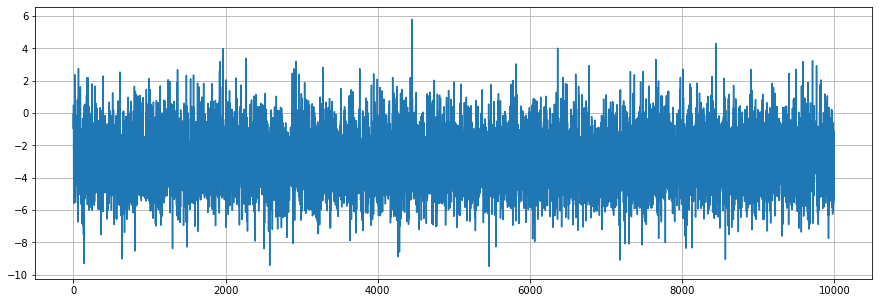

In [15]:
plt.figure(figsize=(15,5))
plt.plot(r2e_lr)
plt.grid(True)

In [16]:
r2e_lsvc = lsvc.decision_function(X2)
fp_lsvc,tp_lsvc,t_lsvc=skm.roc_curve(y2b,r2e_lsvc)

r1_lsvc=np.sum(y2e_lsvc[y2b==1]==1)/(np.sum(y2e_lsvc[y2b==1]==1)+np.sum(y2e_lsvc[y2b==1]==0)) #recall
p1_lsvc=np.sum(y2e_lsvc[y2b==1]==1)/(np.sum(y2e_lsvc[y2b==1]==1)+np.sum(y2e_lsvc[y2b==0]==1)) #precision
f1_lsvc=np.sum(y2e_lsvc[y2b==0]==1)/(np.sum(y2e_lsvc[y2b==0]==0)+np.sum(y2e_lsvc[y2b==0]==1)) #fp-rate

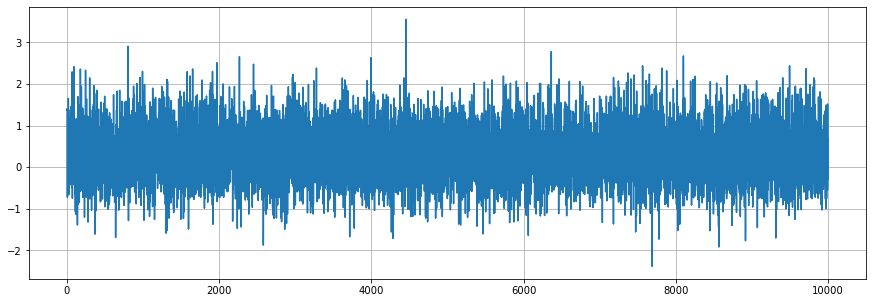

In [17]:
plt.figure(figsize=(15,5))
plt.plot(r2e_lsvc)
plt.grid(True)

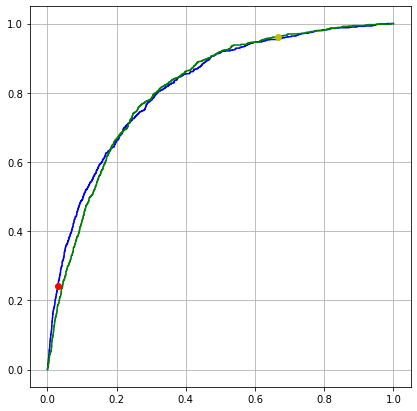

In [18]:

plt.figure(figsize=(7,7))
plt.plot(fp_lr,tp_lr, "b")
plt.plot(fp_lsvc,tp_lsvc, "g")

plt.plot(f1_lr,r1_lr, "or")
plt.plot(f1_lsvc,r1_lsvc, "oy")

plt.axis('scaled')
plt.grid(True)

Pode-se observar que a partir da curva de ROC e com o thershold default os modelos terão um comportamento não balanceado em termos de recall e false alarm rate, porém dependendo do problema estes valores poderão ser modificados.

In [19]:
print("--------------------LinearSVC---------------------------")
y2e_lsvc=lsvc.predict(X2)
print(classification_report(y2b,y2e_lsvc))
print("---------------------------------------------------")
y1e_lsvc=lsvc.predict(X1)
print(classification_report(y1b,y1e_lsvc))
print("-----------------------LogisticRegression-------------------------")
y2e_lr=lr.predict(X2)
print(classification_report(y2b,y2e_lr))
print("-------------------------------------------------------------")
y1e_lr=lr.predict(X1)
print(classification_report(y1b,y1e_lr))

--------------------LinearSVC---------------------------
              precision    recall  f1-score   support

           0       0.99      0.33      0.50      9000
           1       0.14      0.96      0.24      1000

    accuracy                           0.40     10000
   macro avg       0.56      0.65      0.37     10000
weighted avg       0.90      0.40      0.47     10000

---------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.35      0.52     45000
           1       0.14      0.98      0.25      5000

    accuracy                           0.41     50000
   macro avg       0.57      0.67      0.38     50000
weighted avg       0.91      0.41      0.49     50000

-----------------------LogisticRegression-------------------------
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      9000
           1       0.47      0.24      0.32      1000

    ac

Pode-se observar que tal como esperado em ambos os casos para o conjunto de treino os resultados serão melhores uma vez que foi com estes dados que os modelos foram treinados. Porém pode-se observar que para o ocnjunto de teste os valores são aproximados o que demoonstra que o modelo não ficou overfitted.

### Data Normalization

Caso se esteja a trabalhar com um dataset  na qual algumas amostras tenham uma variancia magnitudes acima das outras poderá dominar a função de erro fazendo com que o modelo não consiga aprender corretamente com as restantes amostras. Para tal aplicou-se o StandardScaler que é uma função que remove a média sobre as amostras e torna a vanciancia unitária.

Alguns modelos assumem à-priori que os dados já se encontram normalizados estes apenas teram o performance desejados após a aplicação desta operação, como por exemplo o LinearSVC. 

In [9]:
sc=StandardScaler().fit(X1)
X1s=sc.transform(X1)
X2s=sc.transform(X2)

Text(0.5, 1.0, 'Standard Deviation after normalization')

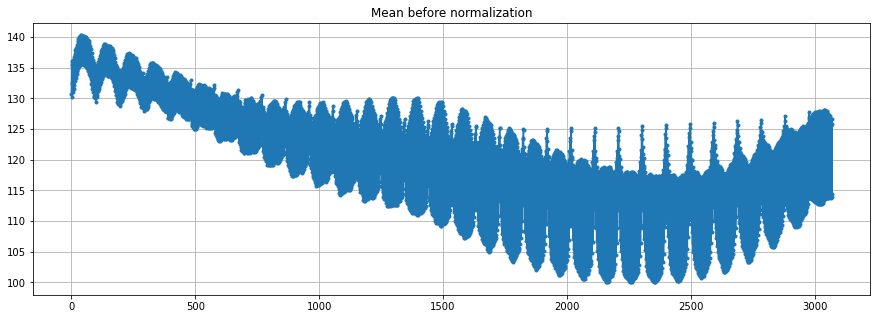

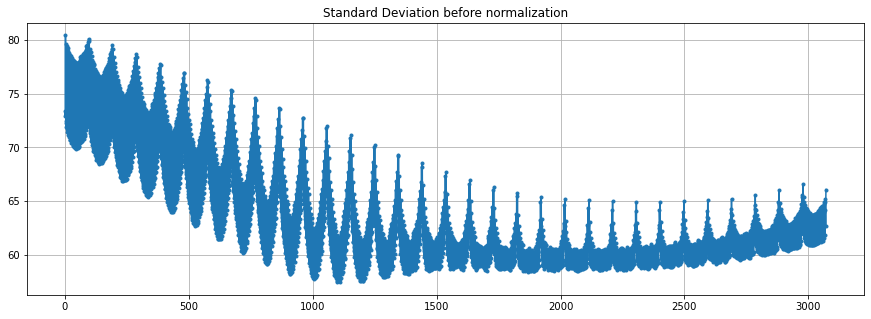

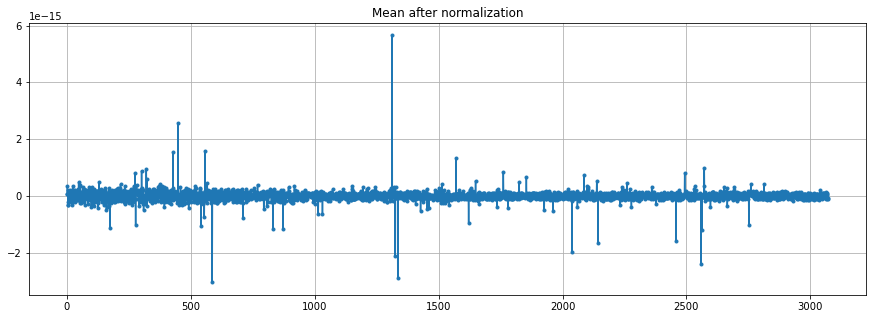

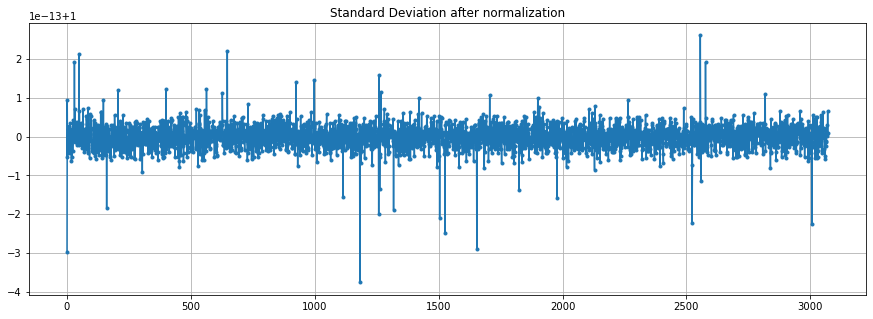

In [21]:
m=np.mean(X1,axis=0)
plt.figure(figsize=(15,5))
plt.plot(m,'.-')
plt.grid(True)
plt.title('Mean before normalization')

s=np.std(X1,axis=0)
plt.figure(figsize=(15,5))
plt.plot(s,'.-')
plt.grid(True)
plt.title('Standard Deviation before normalization')


m=np.mean(X1s,axis=0)
plt.figure(figsize=(15,5))
plt.plot(m,'.-')
plt.grid(True)
plt.title('Mean after normalization')

s=np.std(X1s,axis=0)
plt.figure(figsize=(15,5))
plt.plot(s,'.-')
plt.grid(True)
plt.title('Standard Deviation after normalization')

Após a normalização pode-se desenhar os graficos da média e da variancia através do qual se pode observar que a média e a variancia fica em torno do 0.

In [ ]:
lr=LogisticRegression(
    C = gs_lr.best_params_.get("C"),
    solver = gs_lr.best_params_.get("solver"),
    penalty = gs_lr.best_params_.get("penalty"),
    random_state=42, 
    max_iter=max_iter,
    ).fit(X1s,y1b)

In [22]:
lsvc=LinearSVC(
    C = gs_lsvc.best_params_.get("C"),
    loss = gs_lsvc.best_params_.get("loss"),
    penalty = gs_lsvc.best_params_.get("penalty"),
    random_state=42, 
    max_iter=max_iter,
    ).fit(X1s,y1b)

c:\Users\Mihail Ababii\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [24]:
y2e_lr=lr.predict(X2s)

print()
print(confusion_matrix(y2b,y2e_lr))
print('Total number of erros %d (in %d)'%(np.sum(y2b!=y2e_lr),y2b.shape[0]))


[[8782  218]
 [ 730  270]]
Total number of erros 948 (in 10000)


In [23]:
y2e_lsvc=lsvc.predict(X2s)
print()
print(confusion_matrix(y2b,y2e_lsvc))
print('Total number of erros %d (in %d)'%(np.sum(y2b!=y2e_lsvc),y2b.shape[0]))


[[7730 1270]
 [ 418  582]]
Total number of erros 1688 (in 10000)


Através da observação das matrizes de confuzão acima, podemos visializar que o LogisticRegression (lr), apresenta um nummero ligeiramente nemor de erros, tendo melhorado tanto os True Positives, como o True Negative.

Em contra-partida, o classificador LinearSVC (lsvc), aumentou o numero total de erros apresentando uma melhoria do True Positives, acompanhado da diminuição significativa dos True Negatives.

In [26]:
r2e_lr = lr.decision_function(X2s)
fp_lr, tp_lr, t_lr=skm.roc_curve(y2b,r2e_lr)

r1_lr=np.sum(y2e_lr[y2b==1]==1)/(np.sum(y2e_lr[y2b==1]==1)+np.sum(y2e_lr[y2b==1]==0)) #recall
p1_lr=np.sum(y2e_lr[y2b==1]==1)/(np.sum(y2e_lr[y2b==1]==1)+np.sum(y2e_lr[y2b==0]==1)) #precision
f1_lr=np.sum(y2e_lr[y2b==0]==1)/(np.sum(y2e_lr[y2b==0]==0)+np.sum(y2e_lr[y2b==0]==1)) #fp-rate

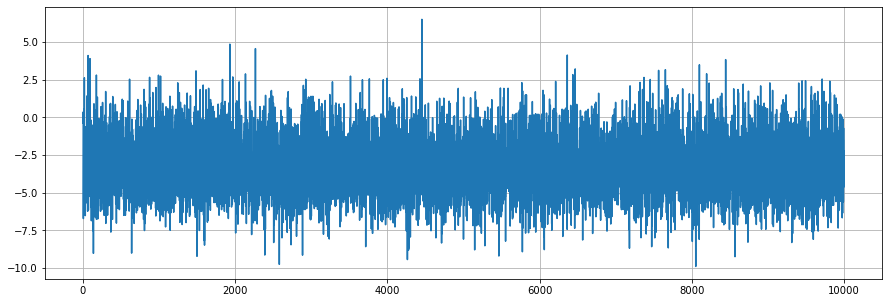

In [27]:
plt.figure(figsize=(15,5))
plt.plot(r2e_lr)
plt.grid(True)

In [28]:
r2e_lsvc = lsvc.decision_function(X2s)
fp_lsvc,tp_lsvc,t_lsvc=skm.roc_curve(y2b,r2e_lsvc)

r1_lsvc=np.sum(y2e_lsvc[y2b==1]==1)/(np.sum(y2e_lsvc[y2b==1]==1)+np.sum(y2e_lsvc[y2b==1]==0)) #recall
p1_lsvc=np.sum(y2e_lsvc[y2b==1]==1)/(np.sum(y2e_lsvc[y2b==1]==1)+np.sum(y2e_lsvc[y2b==0]==1)) #precision
f1_lsvc=np.sum(y2e_lsvc[y2b==0]==1)/(np.sum(y2e_lsvc[y2b==0]==0)+np.sum(y2e_lsvc[y2b==0]==1)) #fp-rate

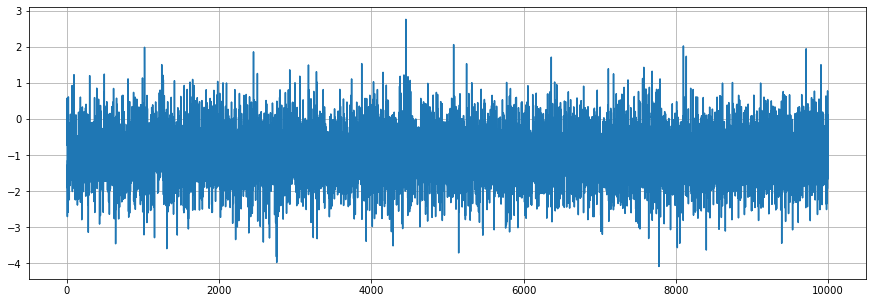

In [29]:
plt.figure(figsize=(15,5))
plt.plot(r2e_lsvc)
plt.grid(True)

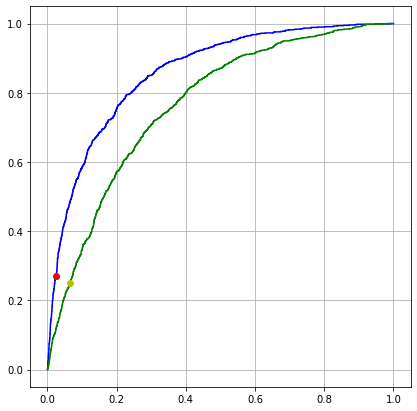

In [30]:

plt.figure(figsize=(7,7))
plt.plot(fp_lr,tp_lr, "b")
plt.plot(fp_lsvc,tp_lsvc, "g")

plt.plot(f1_lr,r1_lr, "or")
plt.plot(f1_lsvc,r1_lsvc, "oy")

plt.axis('scaled')
plt.grid(True)

In [31]:
print("--------------------LinearSVC---------------------------")
y2e_lsvc=lsvc.predict(X2s)
print(classification_report(y2b,y2e_lsvc))
print("---------------------------------------------------")
y1e_lsvc=lsvc.predict(X1s)
print(classification_report(y1b,y1e_lsvc))
print("-----------------------LogisticRegression-------------------------")
y2e_lr=lr.predict(X2s)
print(classification_report(y2b,y2e_lr))
print("-------------------------------------------------------------")
y1e_lr=lr.predict(X1s)
print(classification_report(y1b,y1e_lr))

--------------------LinearSVC---------------------------
              precision    recall  f1-score   support

           0       0.92      0.93      0.93      9000
           1       0.30      0.25      0.27      1000

    accuracy                           0.87     10000
   macro avg       0.61      0.59      0.60     10000
weighted avg       0.86      0.87      0.86     10000

---------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.95      0.94     45000
           1       0.40      0.32      0.35      5000

    accuracy                           0.88     50000
   macro avg       0.66      0.63      0.64     50000
weighted avg       0.87      0.88      0.88     50000

-----------------------LogisticRegression-------------------------
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      9000
           1       0.55      0.27      0.36      1000

    ac

## Multi-class classification

Stochastic Gradient Descent(SGD) é um método iterativo que procura otimizar uma função objetivo. Isto é feito através do cálculo do gradiente da função de custo. Este modelo para as amostras escolhidas como treino irá calcular o gradiente e escolhe "seguir" o caminho que irá diminuir o gradiente. Este modelo poderá no entanto ter problemas com minimos locais na qual o modelo pensa que está no ponto ótimo quando poderia haver outros caminhos que levariam a melhores resultados. Para resolver este problema existem diversa técnicas que permitem diminuir este efeito, tal como o momentum.

### GridSearch

In [ ]:
sgd=SGDClassifier(random_state=42, max_iter=max_iter)

params = {
    "loss" : ["hinge", "log", "squared_hinge"],
    "alpha" : [0.05, 0.1,0.3,0.5],
    "penalty" : ["l2", "l1"],
}
 
gs_sgd = GridSearchCV(sgd, param_grid=params).fit(X1, y1)

C:\Users\A43866\Anaconda3\envs\IASC\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\A43866\Anaconda3\envs\IASC\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\A43866\Anaconda3\envs\IASC\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\A43866\Anaconda3\envs\IASC\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\A43866\

In [ ]:
print(gs_sgd.best_params_)

### CLassification

In [28]:
#Before data normalization
sgd=SGDClassifier(
    #loss = gs_lr.best_params_.get("loss"),
    #alpha = gs_lr.best_params_.get("alpha"),
    #penalty = gs_lr.best_params_.get("penalty"),
    random_state=42, 
    max_iter=500,
    ).fit(X1,y1)

In [29]:
y2e_sgd=sgd.predict(X2)

print(confusion_matrix(y2,y2e_sgd))
print('Total number of erros %d (in %d)'%(np.sum(y2!=y2e_sgd),y2.shape[0]))

[[737   3  13   5  43  81   8  39   5  66]
 [280 109  18  23  86 136  38  74   4 232]
 [244   3 116   9 192 211  68 115   2  40]
 [187   1  41  35 154 308 100  90   3  81]
 [169   0  53   9 351 174  76 132   1  35]
 [136   4  36  21 164 440  49  98   1  51]
 [114   1  49  18 171 259 268  74   1  45]
 [184   1  24   4 128 140  28 407   1  83]
 [557   7  12  11  63 138  14  30  23 145]
 [357  12  14   7  47  81  31  71   0 380]]
Total number of erros 7134 (in 10000)


### Data Normalization

In [30]:
#After data normalization
sgd=SGDClassifier(
    #loss = gs_lr.best_params_.get("loss"),
    #alpha = gs_lr.best_params_.get("alpha"),
    #penalty = gs_lr.best_params_.get("penalty"),
    random_state=42, 
    max_iter=500,
    ).fit(X1s,y1)

c:\Users\Mihail Ababii\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


In [31]:
y2e_sgd_norm=sgd.predict(X2s)

print(confusion_matrix(y2,y2e_sgd_norm))
print('Total number of erros %d (in %d)'%(np.sum(y2!=y2e_sgd_norm),y2.shape[0]))

[[254  21 156  63  56 196   7 119 106  22]
 [ 24 299  59 128  53 119  28 166  37  87]
 [ 37   9 300  95 118 156  50 213  14   8]
 [ 16  10 157 170  98 230  71 226  10  12]
 [ 11   1 161  83 262 134  77 261   6   4]
 [ 15  15 121 112 132 343  52 183  21   6]
 [  1   3 133 160  96 125 276 198   2   6]
 [ 14   5 132  69 110 153  19 458  14  26]
 [ 41  27  91 109  67 194   8  99 319  45]
 [ 27  83  66 127  40 109  24 191  49 284]]
Total number of erros 7035 (in 10000)


### PCA

O Principal Component Analysis (PCA) é um procedimento matemático que transforma um conjunto de dados de alta dimensionalidade noutro conjunto de menor dimensionalidade mantendo a informação mais relevante. Isto é feito através de transformações ortogonais que encontram vetores ortogonais entre si que representem o dataset original com o objetico de minimizar a distancia média quadrática. Cada componente principal será uma combinação linear ou mistura das variaveis iniciais, na qual a primeira componente será a que representa a maior variancia dos dados. Deste modo ao se escolher um numero inferior de componentes iremos diminuir a dimensão porém mantendo a maioria da variancia  e por isso dos dados. 

Tal como os modelos de classificação deve ser aplicada uma normalização da data previamente à aplicação do PCA uma vez que atributos com variancia alta podem influenciar o ersultado fazendo com que as restantes não sejam devidamente fitted.

In [32]:
#PCA DEVE SER APLICADO COM OS DADOS DO STANDARDSCALER

#pca=PCA(random_state=42)

#params = {
    #"n_components" : [0.5,0.7,0.9],
    #"whiten" : [True,False],
#}
 
#gs_pca = GridSearchCV(pca, param_grid=params).fit(X1)

In [10]:
pca=PCA( n_components = .9,#gs_pca.best_params_.get("n_components"), 
        whiten = True,#gs_pca.best_params_.get("whiten")
       ).fit(X1s)
X1p=pca.transform(X1s)
X2p=pca.transform(X2s)
print('Nº of Principal Components kept: %d'%X1p.shape[1])

Nº of Principal Components kept: 103


In [11]:
sgd=SGDClassifier(
    #loss = gs_lr.best_params_.get("loss"),
    #alpha = gs_lr.best_params_.get("alpha"),
    #penalty = gs_lr.best_params_.get("penalty"),
    random_state=42, 
    max_iter=500,
    ).fit(X1p,y1)

In [12]:
y2e_sgd_pca=sgd.predict(X2p)

print(confusion_matrix(y2,y2e_sgd_pca))
print('Total number of erros %d (in %d)'%(np.sum(y2!=y2e_sgd_pca),y2.shape[0]))

[[416  47  72  35  56  64  22  69 165  54]
 [ 94 458  59  29  35  42  31  65  78 109]
 [125  53 123  92 214 108 113 100  41  31]
 [ 63  83  65 183 130 182 116  79  29  70]
 [ 50  42 106  71 303  80 142 149  27  30]
 [ 65  67  71 154 101 265  90 105  49  33]
 [ 34  49  65 113 198  94 310  81  14  42]
 [ 76  60  69  63 111  85  63 380  32  61]
 [175  95  56  36  32  69  19  38 383  97]
 [ 84 219  48  42  33  42  43  81  81 327]]
Total number of erros 6852 (in 10000)


Tal como podemos observar atravéz das matrizes acima, o numero de erros diminui a cada tratamento de dados realizado, pelo que se deve aplicar este tipo de tratamentos, quando o uso SGDClassifier esteja em causa

De modo a demonstrar iluminancia, concluimos tambem que em classificação multi-class o max_iter é mais importante para obter valores melhores, visto que a complexidade do problema aumentou.